# Bitcoin Zaman Serisi Analizi  LSTM Yöntemi

#### Model eğitimi için gerekli kütüphaneleri aktif ediyoruz

In [103]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline 
import quandl

####  Quandl api get komutu ile BTC/USD verilerini çekiyoruz 

In [70]:
dataset = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
dataset.info() #Veri Bilgileri

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1593 entries, 2014-01-07 to 2018-05-18
Data columns (total 7 columns):
Open                 1593 non-null float64
High                 1593 non-null float64
Low                  1593 non-null float64
Close                1593 non-null float64
Volume (BTC)         1593 non-null float64
Volume (Currency)    1593 non-null float64
Weighted Price       1593 non-null float64
dtypes: float64(7)
memory usage: 99.6 KB


#### Veri ilk satırlarını görüntüle

In [71]:
dataset.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


#### Son verileri görüntüleme

In [72]:
dataset.tail() 

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-05-14,8698.2,8886.3,8286.3,8660.8,6017.889135,5.175156e+07,8599.619888
2018-05-15,8661.6,8862.0,8421.0,8462.8,3875.260105,3.337634e+07,8612.670738
2018-05-16,8473.1,8494.0,8077.3,8344.9,6332.933768,5.230912e+07,8259.856574
2018-05-17,8345.8,8500.0,7978.8,8064.0,4246.838941,3.495196e+07,8230.112561
2018-05-18,8064.0,8280.0,7932.5,8229.3,4027.719430,3.258180e+07,8089.391518


#### Ortalama kapanış değeri çizgi grafiği `Weighted Price`

In [73]:
traceBtc = go.Scatter(x=dataset.index, y=dataset['Weighted Price'], name= 'Price')
py.iplot([traceBtc])

#### Fill metodu ile 0 verilerini doldurma

In [74]:
dataset['Weighted Price'].replace(0, np.nan, inplace=True)
dataset['Weighted Price'].fillna(method='ffill', inplace=True)

#### Yeni doldurulmş değerler ile yeni grafik `Weighted Price

In [75]:
traceBtc = go.Scatter(x=dataset.index, y=dataset['Weighted Price'], name= 'Price')
py.iplot([traceBtc])

### LSTM modelin eğitimi için ortalama kapanış fiyatının(`Weighted Price`) kullanılması. 

#### Ortalama Kapanış Fiyatının(`Weighted Price`) MinMaxScaler ile değerinin normalize edilmesi 

In [76]:
from sklearn.preprocessing import MinMaxScaler
deger = dataset['Weighted Price'].values.reshape(-1,1)
deger = deger.astype('float32')
scData = MinMaxScaler(feature_range=(0, 1))
normVeri = scData.fit_transform(deger)

#### Verinin Split edilmesi ayrılması işlemi %70 Eğitim verisi %30 test verisi olarak kullanılacaktır.

In [77]:
egitimSayisi = int(len(normVeri) * 0.7)
testSayisi = len(normVeri) - egitimSayisi
egitim,test = normVeri[0:egitimSayisi,:], normVeri[egitimSayisi:len(normVeri),:]
print(len(egitim), len(test))

1115 478


#### Veri setimizi Oluşturuyoruz

In [78]:
def veri_Set(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Tanımladığımız ('veri_Set') foksiyonunu ile Test ve Eğitim Verisindeki X,Y değerlerinin belirliyoruz. 

In [79]:
look_back = 1
egitimX, egitimY = veri_Set(egitim, look_back)
testX, testY = veri_Set(test, look_back)

1114
477


#### Modelin eğitimi için X değerlerini revize ediyoruz.

In [80]:
egitimX = np.reshape(egitimX, (egitimX.shape[0], 1, egitimX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### LSTM modelimizi oluşturuyoruz ve  300 adım sayısı(epoch) belirliyoruz

In [81]:
modelstm = Sequential()
modelstm.add(LSTM(100, input_shape=(egitimX.shape[1], egitimX.shape[2])))
modelstm.add(Dense(1))
modelstm.compile(loss='mae', optimizer='adam')
model_egitim = modelstm.fit(egitimX, egitimY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

#### Adımlara veri kaybını grafikselleştirilmesi.

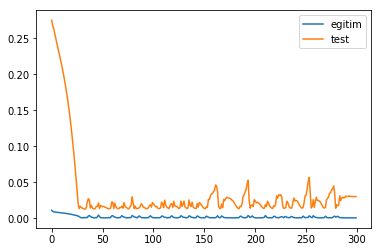

In [82]:
pyplot.plot(model_egitim.history['loss'], label='egitim')
pyplot.plot(model_egitim.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Çizgi grafik kullanarak tahmin ve gerçek değer çizimi.

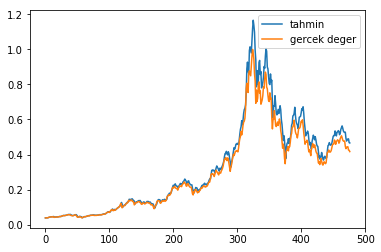

In [83]:
y = modelstm.predict(testX)
pyplot.plot(y, label='tahmin')
pyplot.plot(testY, label='gercek deger')
pyplot.legend()
pyplot.show()

#### Verileri De-Normalizde ediyoruz

In [84]:
yDenormalize = scData.inverse_transform(y.reshape(-1, 1))
testyDenormalize = scData.inverse_transform(testY.reshape(-1, 1))

#### RMSE Hesabı (Root Mean Square Error)
Hata ortalama büyüklüğünü ölçen, tahmin ile gerçek gözlem arasındaki farkın karesinin ortalamasının kareköküdür.





In [85]:
rmse = sqrt(mean_squared_error(testyDenormalize, yDenormalize))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 968.898


#### USD cinsinden grafik

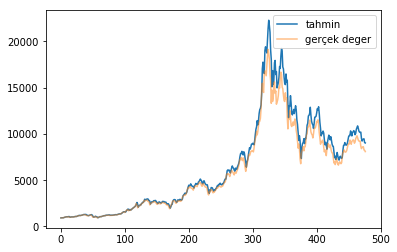

In [86]:
pyplot.plot(yDenormalize, label='tahmin')
pyplot.plot(testyDenormalize, label='gerçek deger', alpha=0.5)
pyplot.legend()
pyplot.show()

#### X Girdilerini tarih veri setine dönüştürme

In [87]:
gercekTarih = dataset.tail(len(testX)).index

#### Y verilerimizi denormalize ediyoruz

In [88]:
testY_res = yDenormalize.reshape(len(yDenormalize))
yhat_res = testyDenormalize.reshape(len(testyDenormalize))

#### Plot Tahmin Değeri ve Gerçek değerini grafik haline dönüştürüyoruz  X=Tarih, Y=USD

In [89]:
gercek = go.Scatter(x=gercekTarih, y=testY_res, name= 'Gercek Deger')
tahmin = go.Scatter(x=gercekTarih, y=yhat_res, name= 'Tahmin Değer')
py.iplot([tahmin, gercek])

### Model için ek özellikler

#### NA / null değerleri hariç, kolonların çift yönlü korelasyonunu Hesaplama  `Weighted Price`

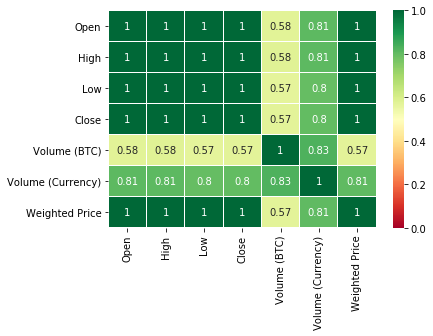

In [90]:
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Sonuç: `Volume` düzeltildi  `Weighted Price`. 
`Open`, `High`, `Low`, `Close` kolonları `Weighted Price` değeri ile doğrudan ilgili

#### Zaman Serisi ve Denetimli Öğrenme Fonksiyonu

In [91]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Tüm veri değerlerini alıyoruz

In [92]:
deger = dataset[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
deger = deger.astype('float32')
deger

array([[8.4183551e+02, 1.5622378e+01, 1.3151473e+04],
       [8.3915625e+02, 1.9182756e+01, 1.6097329e+04],
       [8.3157294e+02, 8.1583347e+00, 6.7842500e+03],
       ...,
       [8.2598564e+03, 6.3329336e+03, 5.2309124e+07],
       [8.2301123e+03, 4.2468389e+03, 3.4951964e+07],
       [8.0893916e+03, 4.0277195e+03, 3.2581800e+07]], dtype=float32)

#### Verileri 0,1 arasında normalize ediyoruz.

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalizeData = scaler.fit_transform(deger)

#### Zaman Serisi ve Denetimli Öğrenme Fonksiyonu

In [94]:
sprData = series_to_supervised(normalizeData, 1, 1)
sprData.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.033915,0.000542,0.000067,0.033773,0.000666,0.000082
2,0.033773,0.000666,0.000082,0.033373,0.000283,0.000035
3,0.033373,0.000283,0.000035,0.034079,0.000279,0.000035
4,0.034079,0.000279,0.000035,0.036494,0.000651,0.000086
5,0.036494,0.000651,0.000086,0.034898,0.000883,0.000112


#### Nan/0 sutunlarını temizleme

In [95]:
sprData.drop(sprData.columns[[4,5]], axis=1, inplace=True)
print(sprData.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.033915   0.000542   0.000067  0.033773
2   0.033773   0.000666   0.000082  0.033373
3   0.033373   0.000283   0.000035  0.034079
4   0.034079   0.000279   0.000035  0.036494
5   0.036494   0.000651   0.000086  0.034898


#### Veri setini % 70 eğitim,% 30 test verisi olarak ayırma

In [96]:
deger = sprData.values
n_train_hours = int(len(deger) * 0.7)
train = deger[:n_train_hours, :]
test = deger[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1114, 1, 3) (1114,) (478, 1, 3) (478,)


#### LSTM modelimizi oluşturuyoruz ve  300 adım sayısı(epoch) belirliyoruz

In [97]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

#### Adımlara veri kaybını grafikselleştirilmesi.

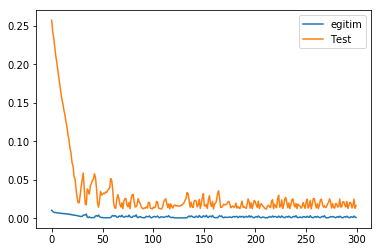

In [98]:
pyplot.plot(multi_history.history['loss'], label='egitim')
pyplot.plot(multi_history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

#### Çizgi grafik kullanarak tahmin ve gerçek değer çizimi.

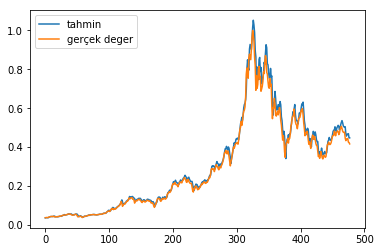

In [99]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='tahmin')
pyplot.plot(test_y, label='gerçek deger')
pyplot.legend()
pyplot.show()

#### Y verilerimizi denormalize ediyoruz

In [100]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE Hesabı (Root Mean Square Error)
Hata ortalama büyüklüğünü ölçen, tahmin ile gerçek gözlem arasındaki farkın karesinin ortalamasının kareköküdür.





In [101]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 541.201


#### Gerçek fiyatlı çizgi grafiği, "Ağırlıklı Fiyat" özelliği ile öngörülen fiyat, Hacim ve Ağırlıklı Fiyat özelliklerine göre öngörülen fiyat

In [102]:
tahmin = go.Scatter(x=gercekTarih, y=inv_y, name= 'Gercek Deger')
coklutahmin = go.Scatter(x=gercekTarih, y=inv_yhat, name= 'Çoklu  Tahmin Fiyatı')
gercek = go.Scatter(x=gercekTarih, y=yhat_res, name= 'Tahmin Fiyat')
py.iplot([gercek, coklutahmin, tahmin])

# SONUÇ
- LSTM `Weighted Price`  RMSE HATA 968.898
- ÇOKLU LSTM  `Volume(BTC)`, `Volume(Currency)`, `Weighted Price`  RMSE HATA 541.201
- Birden çok özellikli LSTM, yukarıdaki çizgi grafikte gösterildiği gibi daha doğru sonuçlar gösterir.